# 1. Explain features

## Index
time
Time of the readings, with a **time span of 1 minute,** all timestamps are presented in **UNIX system**
## Energy Usage

### General
use [kW] Total energy consumption  
gen [kW] Total energy generated by means of solar or other power generation resources  
House overall [kW] overall house energy consumption 

### Appliances 
Dishwasher [kW] energy consumed by specific appliance  
Furnace 1 [kW] energy consumed by specific appliance  
Furnace 2 [kW] energy consumed by specific appliance  
Home office [kW] energy consumed by specific appliance  
Fridge [kW] energy consumed by specific appliance  
Wine cellar [kW] energy consumed by specific appliance  
Garage door [kW] energy consumed by specific appliance  
Microwave [kW] energy consumed by specific appliance  
Barn [kW] energy consumed by specific appliance  
Well [kW] energy consumed by specific appliance  

### Rooms
Kitchen 12 [kW] energy consumption in kitchen 1  
Kitchen 14 [kW] energy consumption in kitchen 2  
Kitchen 38 [kW] energy consumption in kitchen  
Living room [kW] energy consumption in Living room 

### Generated electricity
Solar [kW] Solar power generation  

## Weather
**temperature:**
temperature is a physical quantity expressing hot and cold. 

**humidity:**
Humidity is the concentration of water vapour present in air. 

**visibility:**
Visibility sensors measure the meteorological optical range which is defined as the length of atmosphere over which a beam of light travels before its luminous flux is reduced to 5% of its original value.  

**apparentTemperature:**

Apparent temperature is the temperature equivalent perceived by humans, caused by the combined effects of air temperature, relative humidity and wind speed. The measure is most commonly applied to the perceived outdoor temperature.

**pressure:**
Falling air pressure indicates that bad weather is coming, while rising air pressure indicates good weather

**windSpeed:**
Wind speed, or wind flow speed, is a fundamental atmospheric quantity caused by air moving from high to low pressure, usually due to changes in temperature.

**cloudCover:**
Cloud cover (also known as cloudiness, cloudage, or cloud amount) refers to the fraction of the sky obscured by clouds when observed from a particular location. Okta is the usual unit of measurement of the cloud cover.

**windBearing:**
In meteorology, an azimuth of 000° is used only when no wind is blowing, while 360° means the wind is from the North. True Wind Direction True North is represented on a globe as the North Pole. All directions relative to True North may be called "true bearings."

**dewPoint:**
the atmospheric temperature (varying according to pressure and humidity) below which water droplets begin to condense and dew can form.

**precipProbability:**
A probability of precipitation (POP), also referred to as chance of precipitation or chance of rain, is a measure of the probability that at least some minimum quantity of precipitation will occur within a specified forecast period and location.

**precipIntensity:**
The intensity of rainfall is a measure of the amount of rain that falls over time. The intensity of rain is measured in the height of the water layer covering the ground in a period of time. It means that if the rain stays where it falls, it would form a layer of a certain height.

# 2. Import relevant libraries

In [3]:
import numpy as np
import pandas as pd
import piplite
await piplite.install('seaborn')
from scipy.stats import shapiro
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sb

In [4]:
df = pd.read_csv('HomeC.csv', low_memory = False)
# we do low memory because some columns have mixed data types and thus we don't want to import them with generalization
print(f'HomeC.csv : {df.shape}')
df.columns

HomeC.csv : (503911, 32)


Index(['time', 'use [kW]', 'gen [kW]', 'House overall [kW]', 'Dishwasher [kW]',
       'Furnace 1 [kW]', 'Furnace 2 [kW]', 'Home office [kW]', 'Fridge [kW]',
       'Wine cellar [kW]', 'Garage door [kW]', 'Kitchen 12 [kW]',
       'Kitchen 14 [kW]', 'Kitchen 38 [kW]', 'Barn [kW]', 'Well [kW]',
       'Microwave [kW]', 'Living room [kW]', 'Solar [kW]', 'temperature',
       'icon', 'humidity', 'visibility', 'summary', 'apparentTemperature',
       'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity',
       'dewPoint', 'precipProbability'],
      dtype='object')

## 3.1 Deal with missing values


In [17]:
df.isnull().sum()
# fortunately, we have only one 1min in which we have missing values -> drop the row

time                   0
use [kW]               1
gen [kW]               1
House overall [kW]     1
Dishwasher [kW]        1
Furnace 1 [kW]         1
Furnace 2 [kW]         1
Home office [kW]       1
Fridge [kW]            1
Wine cellar [kW]       1
Garage door [kW]       1
Kitchen 12 [kW]        1
Kitchen 14 [kW]        1
Kitchen 38 [kW]        1
Barn [kW]              1
Well [kW]              1
Microwave [kW]         1
Living room [kW]       1
Solar [kW]             1
temperature            1
icon                   1
humidity               1
visibility             1
summary                1
apparentTemperature    1
pressure               1
windSpeed              1
cloudCover             1
windBearing            1
precipIntensity        1
dewPoint               1
precipProbability      1
dtype: int64

In [19]:
df.columns = [i.replace(' [kW]', '') for i in df.columns]
print(df.columns)
df_copy = df.copy()
print(df_copy.shape)
df_copy = df_copy.dropna(axis=0)
#check for drop
df_copy.columns.count()


Index(['time', 'use', 'gen', 'House overall', 'Dishwasher', 'Furnace 1',
       'Furnace 2', 'Home office', 'Fridge', 'Wine cellar', 'Garage door',
       'Kitchen 12', 'Kitchen 14', 'Kitchen 38', 'Barn', 'Well', 'Microwave',
       'Living room', 'Solar', 'temperature', 'icon', 'humidity', 'visibility',
       'summary', 'apparentTemperature', 'pressure', 'windSpeed', 'cloudCover',
       'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability'],
      dtype='object')
(503911, 32)


<class 'AttributeError'>: 'Index' object has no attribute 'count'

In [20]:
#check for normal distribution
def ShTest(df):
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    gaussian_cols =[]
    nongaussian_cols=[]
    for i in num_cols:
        p_value = float(shapiro(df[i])[0])
        if p_value > 0.05:
            gaussian_cols.append(i) 
        elif p_value <= 0.05:
            nongaussian_cols.append(i) 
            
    return [gaussian_cols, nongaussian_cols]

ShTest(df_copy)[1]



['Microwave']

# 3.2 Deal with outliers
# 3.2.1 Detection

<AxesSubplot:>

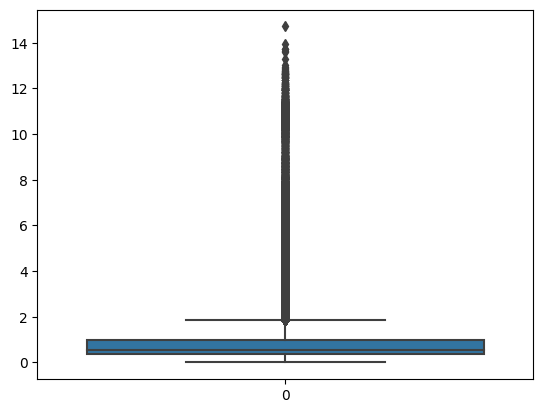

In [88]:
# Step 1 - Box plots for 'use', 'gen' 'House overall' 
sb.boxplot(df['use '])

In [105]:
# We see that this data cannot be treated with box plots, so we switch to other methods of vizualization
# We saw that electricity consumption is gaussian. Let's check, because Z-score can helps us in such case
def z_score_outliers(array):
    z_scores = zscore(array)
    outliers = (z_scores < -2.5) | (z_scores > 2.5)
    
    print(f'Outlier portion: {np.round(array[outliers].count()/array.count(),4)*100}%')
    return array[outliers]
#now we remove the non-gaussian column, as Z-score requires normal distribution
features_z =['use','gen','House overall']
df_z = df_copy.drop('Microwave', axis =1)
outliers_z = pd.DataFrame(z_score_outliers(df_z[features_z]))
#we see over 14k+ outliers

Outlier portion: use              2.94
gen              4.27
House overall    2.94
dtype: float64%


In [56]:
df_copy['temperature'].describe()

count    503910.000000
mean         50.741935
std          19.113807
min         -12.640000
25%          35.770000
50%          50.320000
75%          66.260000
max          93.720000
Name: temperature, dtype: float64

In [110]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score


features = ['use','gen','House overall']


## Create a training-test set (0.8-0.1-0.1)
X = df_copy[features]
train_size=0.8
valid_size=0.1
train_index = (int)(len(df_copy)*train_size)
X_train = X[:train_index]
X_validation=X[train_index:(int)(train_index*(1+valid_size))]
X_test = X[(int)(train_index*(1+valid_size)):]


## Fit Model
clf = IsolationForest(n_estimators=120, max_samples=100, max_features =2)
clf.fit(X_train)



## Get Scores
scores_train = clf.decision_function(X_train)
scores_validation = clf.decision_function(X_validation)
scores_test = clf.decision_function(X_test)
df_copy['scores'] = np.concatenate((scores_train, scores_validation, scores_test), axis=0)

## Get Anomaly labels
df_copy['anomaly'] = clf.predict(X)

## Get Anomalies
outliers_IF = df_copy.loc[df_copy['anomaly'] == -1]






<class 'KeyError'>: 'anomaly'

In [95]:
(outliers['time'].count())/(df_copy['time'].count())
outliers_IF.columns

Index(['time', 'use', 'gen', 'House overall', 'Dishwasher', 'Furnace 1',
       'Furnace 2', 'Home office', 'Fridge', 'Wine cellar', 'Garage door',
       'Kitchen 12', 'Kitchen 14', 'Kitchen 38', 'Barn', 'Well', 'Microwave',
       'Living room', 'Solar', 'temperature', 'icon', 'humidity', 'visibility',
       'summary', 'apparentTemperature', 'pressure', 'windSpeed', 'cloudCover',
       'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability',
       'scores', 'anomaly'],
      dtype='object')

In [89]:
#We got huge difference between z-score and IsolationForests. This means we have to use domain knowledge. 
# High power consuming 2.3 times out of 10 (2.3 days in 10 days) is relatively uncommon
# This means we have to trust the Z-score (0.3 days in 10 days) but still, let's see how many points are common to both detectors
common_indices = [i for i in outliers_z.index if i in outliers_IF.index]
Zoutliers_in_IF = pd.DataFrame(outliers_IF.loc[common_indices])

#(Zoutliers_in_IF.sort_values(by='time')).equals(outliers_z.sort_values(by='time'))

Index(['use'], dtype='object')

# 3.2.2 Treatment

# 4. EDA

<AxesSubplot:>

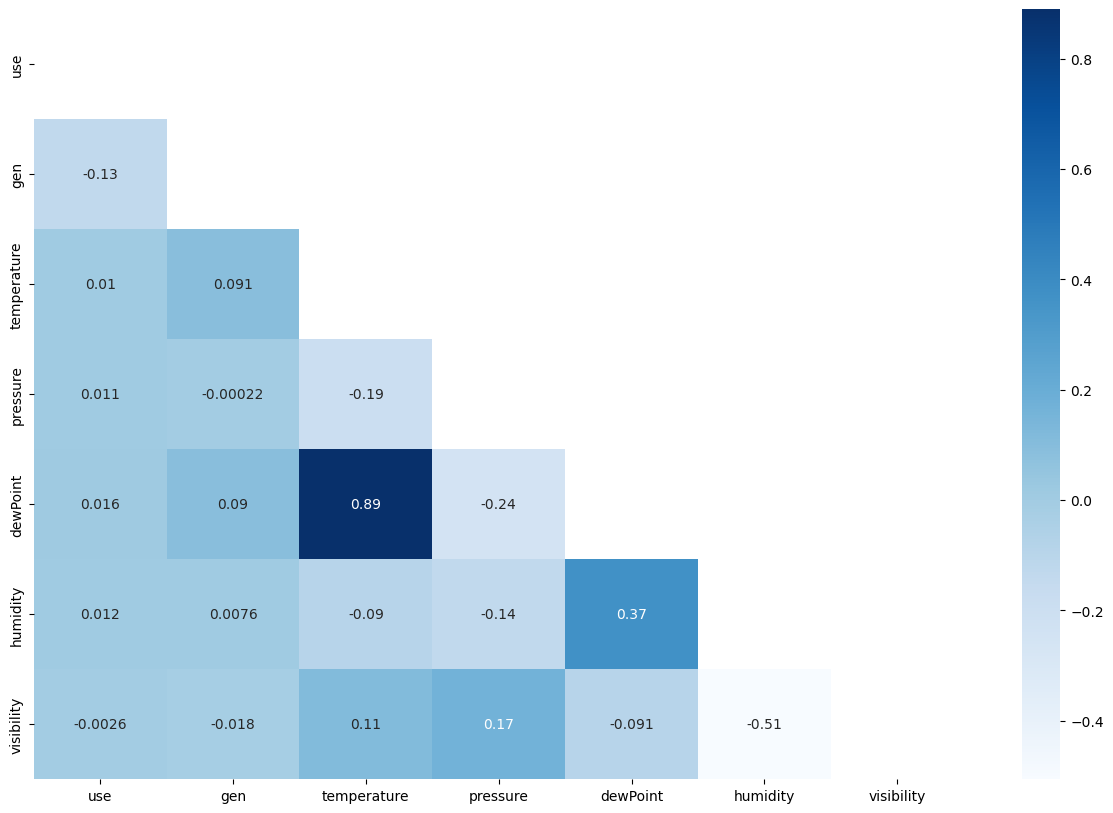

In [23]:
#since all features are continuous in kW (not categorical), let's calculate the pearson correlation


# Define the features you want to include in the heatmap

# Subset the DataFrame to include only those columns corresponding to the features
df_subset = df_copy[['use','gen','temperature','pressure','dewPoint','humidity','visibility']]

# Compute the correlation matrix and create a mask to hide the upper triangle
corr = df_subset.corr(method='pearson')
mask = np.triu(np.ones_like(corr))

# Create the heatmap using the subsetted DataFrame and masked correlation matrix
fig = plt.figure(figsize=(15,10))
sb.heatmap(corr, annot=True, mask=mask, cmap='Blues')

#No apparent correlations between temperature and power usage
